# Neural Network Quantum State



In [1]:
import os
import json
import time

import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax
import ray
# import flax.linen as nn
import netket as nk
import netket.nn as nn

from scipy.sparse.linalg import eigsh
from netket.operator.spin import sigmaz, sigmax 
from ray import tune
from tqdm.autonotebook import tqdm
from IPython.display import display

# Our source code
# Change the imported model to aklt_model etc.
from j1j2_model import OurModel, setup_problem, setup_model, ray_train_loop 

/tmp/ipykernel_25356/1982775363.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
os.environ["JAX_PLATFORM_NAME"] = "cpu" # or gpu
# os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1" # RAY DEBUG
# os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"  # force gpu w/o right drivers

skip_training = False
print(f'{nk.utils.mpi.available=}')

# Force detecting GPU in WSL
ray.shutdown()
ray.init(num_gpus=1)

nk.utils.mpi.available=False


RayContext(dashboard_url='', python_version='3.8.10', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '172.22.24.106', 'raylet_ip_address': '172.22.24.106', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-20_02-25-11_018199_25356/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-20_02-25-11_018199_25356/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-20_02-25-11_018199_25356', 'metrics_export_port': 61934, 'gcs_address': '172.22.24.106:62666', 'address': '172.22.24.106:62666', 'node_id': 'e03545fcea9c41ddea12dfc884e85d1e22c1fa8568336b860b07ed4a'})

In [3]:
if not skip_training:
    from ray.tune.suggest.hyperopt import HyperOptSearch
    
    search_space = {
        'model': {
            'alpha': tune.randint(1, 3+1), # last value exclusive
        },
        # 'activation': tune.choice(['tanh', 'sigmoid']),
        'learning_rate': tune.uniform(0.0, 0.1),
        'n_epochs': 300, #tune.qrandint(100, 300, 50),
        'n_samples': 1008, #tune.qrandint(100, 1000, 100),
    }
    
    metric = "energy_error"
    mode = "min"

    hyperopt_search = HyperOptSearch(metric=metric, mode=mode)
    hyper_band_scheduler = tune.schedulers.ASHAScheduler(
        metric=metric,
        mode=mode,
        max_t=search_space['n_epochs'].max_value if isinstance(search_space['n_epochs'], tune.sample.Sampler) else search_space['n_epochs'],
        grace_period=20
    )

    analysis = tune.run(
        ray_train_loop,
        config=search_space,
        progress_reporter=tune.JupyterNotebookReporter(True, [metric]),
        scheduler=hyper_band_scheduler,
        resources_per_trial={"cpu": 6, 'gpu': 1/2},
        search_alg=hyperopt_search,
        num_samples=10,
        resume='AUTO',
        # metric=metric,
        # mode=mode,
    )

Trial name,status,loc,learning_rate,model/alpha,n_epochs,n_samples,energy_error
ray_train_loop_c0f86430,TERMINATED,172.22.24.106:3190,0.0974686,3,300,1008,48.1697
ray_train_loop_c256204c,TERMINATED,172.22.24.106:3221,0.0950219,2,300,1008,46.5158
ray_train_loop_c258af74,TERMINATED,172.22.24.106:3769,0.0975115,3,300,1008,39.3891
ray_train_loop_cd23d23a,TERMINATED,172.22.24.106:3986,0.0695858,1,300,1008,43.0032
ray_train_loop_d0b71bfa,TERMINATED,172.22.24.106:4586,0.0331873,1,300,1008,23.4126
ray_train_loop_dc0b6330,TERMINATED,172.22.24.106:4619,0.0425044,2,300,1008,50.1842
ray_train_loop_dca49bea,TERMINATED,172.22.24.106:5327,0.0978462,1,300,1008,37.6578
ray_train_loop_eaf23f18,TERMINATED,172.22.24.106:5496,0.0905673,2,300,1008,40.7879
ray_train_loop_eded37c2,TERMINATED,172.22.24.106:5781,0.060277,3,300,1008,41.1898
ray_train_loop_f5147f9c,TERMINATED,172.22.24.106:5971,0.0418486,1,300,1008,46.9368


 99%|█████████▉| 298/300 [00:09<00:00, 30.97it/s, Energy=73.99-0.01j ± 0.11 [σ²=12.48, R̂=1.0240]]
2022-05-20 01:35:45,959	INFO tune.py:701 -- Total run time: 116.20 seconds (116.07 seconds for the tuning loop).


### Select best model parameters

In [14]:
# TODO

hyperparams = {
    'model': {
        'alpha': 1
    },
    'learning_rate': 0.09,
    'n_epochs': 100,
    'n_samples': 1008,
}

H, hi = setup_problem() #Remove the parameter for other models than j1j2. For j1j2 this chooses J2 when J1 = 1.0
eig_vals, _ = eigsh(H.to_sparse(), k=2, which="SA")
vstate, model, trainer = setup_model(H, hi, hyperparams)
display(f'{vstate.n_parameters=}')
log = nk.logging.RuntimeLog()

'vstate.n_parameters=220'

In [17]:
trainer.run(n_iter=hyperparams['n_epochs'], out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ", ffn_energy, error)

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s, Energy=-7.5789+0.0108j ± 0.0021 [σ²=0.0044, R̂=1.0089]]


Optimized energy and relative error:  -7.5728+0.0131j ± 0.0050 [σ²=0.0251, R̂=1.0069] 0.5439151196123783


In [7]:
# TODO load saved model
if skip_training:
    pass


## Results

Text(0, 0.5, 'Energy')

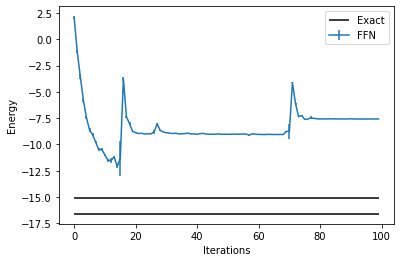

In [18]:
data = log.data

plt.errorbar(data["Energy"].iters, jnp.real(data["Energy"].Mean), yerr=data["Energy"].Sigma, label="FFN")
#plt.hlines([E_gs_analytic], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.hlines([eig_vals], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

### Wavefunctions

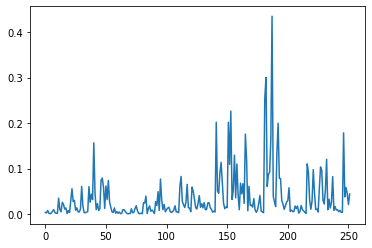

In [16]:
ket = vstate.to_array()

plt.plot(abs(ket))


In [9]:
# get quantum geometric tensor of state
# https://github.com/netket/netket/blob/2a7dded3db4705099d4de5450006b46b32ce34ca/netket/optimizer/qgt/qgt_onthefly_logic.py
qgt = vstate.quantum_geometric_tensor()
qgt

QGTOnTheFly(diag_shift=0.0)

In [10]:
QGT = qgt.to_dense()
jnp.imag(QGT)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

# The AKLT Model

The AKLT model is an extension to the simple 1D Heisenberg spin model, proposed in 1987 by Affleck, I. et al.:

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799

The model is essentially a 1D chain of spin-1/2 nuclei which form pairs. A constraint of having two spin-1/2 nuclei for each site is further imposed, which leads to the system being effectively a spin-1 system. This can be understood then to be a chain of these spin-1 "composite" nuclei. 

In the ground state of this Hamiltonian, every dimerized pair is referred to as a site and is given by a 

The AKLT Hamiltonian is given by a linear combination of the spin-1 projection operators in the respective Hilbert space $$\mathcal{H} \subset \mathbb{C}^3$$.